<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Straitforward" data-toc-modified-id="Straitforward-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Straitforward</a></span></li><li><span><a href="#Siamese-classifier" data-toc-modified-id="Siamese-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Siamese classifier</a></span></li></ul></div>

In [1]:
import keras
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

import os
import cv2
import h5py
import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [3]:
import scipy.io

DATA_PATH = '../data/human_pose'

mat = scipy.io.loadmat(osp.join(DATA_PATH, 'mpii_human_pose_v1_u12_1.mat'))
vals = mat['RELEASE'][0, 0] #<-- set the array you want to access. 
keys = mat['RELEASE'][0, 0].dtype.descr

In [4]:
activities = vals['act']
annotations = np.squeeze(vals['annolist'])
dataset = {}

for i, annotation in enumerate(annotations):
    fname = annotation[0][0][0][0][0]
    activity_id = activities[i][0][2][0][0]
    
    if activity_id != -1:
        if activity_id not in dataset:
            dataset[activity_id] = []
        
        if osp.exists(osp.join(DATA_PATH, 'images', fname)):
            dataset[activity_id].append(cv2.resize(cv2.imread(osp.join(DATA_PATH, 'images', fname)), (224, 224)))

In [5]:
lengths = []

for k, v in dataset.items():
    lengths.append(len(v))

In [6]:
sorted_lengths = list(reversed(np.argsort(lengths)))

In [8]:
dataset.keys()[sorted_lengths[1]]

378

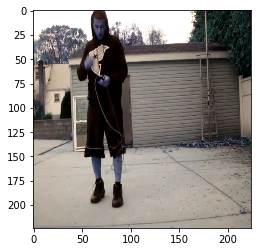

In [9]:
plt.imshow(dataset[dataset.keys()[sorted_lengths[1]]][55])

In [18]:
activity1 = dataset[dataset.keys()[sorted_lengths[0]]] + dataset[dataset.keys()[sorted_lengths[1]]]
activity2 = dataset[dataset.keys()[sorted_lengths[2]]] + dataset[dataset.keys()[sorted_lengths[3]]]

In [19]:
activity1_train, activity1_val = train_test_split(np.asarray(activity1), test_size=0.85)

In [20]:
activity1_train.shape

(48, 224, 224, 3)

In [21]:
activity2_train, activity2_val = train_test_split(np.asarray(activity2), test_size=0.85)

In [22]:
activity2_train.shape

(44, 224, 224, 3)

# Straitforward

In [23]:
model = VGG16(include_top=False, weights=None, input_shape=(224, 224, 3))
model.load_weights('../weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
model.trainable = True

In [24]:
predictor = Flatten()(model.output)
predictor = Dense(1024, activation='elu')(predictor)
predictor = Dense(512, activation='elu')(predictor)
predictor = Dense(1, activation='sigmoid')(predictor)

predictor = keras.Model([model.input], [predictor])
predictor.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [25]:
X_train = np.vstack([activity1_train, activity2_train])
idxs = np.arange(len(X_train))
targets = np.hstack([np.ones(len(activity1_train)), np.zeros(len(activity2_train))])
BATCH_SIZE = 32
NUM_EPOCHS = 1000

predictor.fit(
    X_train[idxs], targets[idxs],
    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
    validation_data=(np.vstack([activity1_val, activity2_val]), np.hstack([np.ones(len(activity1_val)), np.zeros(len(activity2_val))])))

Train on 92 samples, validate on 526 samples
Epoch 1/1000
92/92 [==============================] - 4s 45ms/step - loss: 5.8241 - acc: 0.3913 - val_loss: 2.1002 - val_acc: 0.6407
Epoch 2/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.7949 - acc: 0.8478 - val_loss: 1.6839 - val_acc: 0.6673
Epoch 3/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.3209 - acc: 0.8913 - val_loss: 1.1845 - val_acc: 0.7319
Epoch 4/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.5952 - val_acc: 0.8498
Epoch 5/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4043 - val_acc: 0.8840
Epoch 6/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.3350 - val_acc: 0.8992
Epoch 7/1000
92/92 [==============================] - 2s 25ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3098 - val_acc: 0.9125
Epoch 8/1000
92/92 [====

KeyboardInterrupt: 

# Siamese classifier

In [26]:
import models.siamese

model = models.siamese.build(
    (256, 256, 3), 1024, 128, 'vgg16'
)

# NOTE: doesn't work with keras
# model.compile(
#     loss=lambda y, x: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=x)),
#     optimizer=keras.optimizers.RMSprop(1e-5),
#     metrics=[]
# )

labels = tf.placeholder(tf.float32, name='labels')

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

global_step = tf.Variable(0, trainable=False)
train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
tf.add_to_collection('train_step', train_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [27]:
with np.load('../weights/siamese_pretrained_imagenet.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))][0]

In [28]:
def reset_fused_model_to_pretrained_state():
    tf.reset_default_graph()
    global model
    global input1
    global input2
    global sess
    global train_step
    global loss
    global labels
    
    model = models.siamese.build(
        (256, 256, 3), 1024, 128, 'vgg16'
    )

    labels = tf.placeholder(tf.float32, name='labels')

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

    global_step = tf.Variable(0, trainable=False)
    train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
    tf.add_to_collection('train_step', train_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    input_1 = model.input[0]
    input_2 = model.input[1]
    
    for i, var in enumerate(tf.trainable_variables()[1:]):
        sess.run(var.assign(param_values[i + 1]))

In [29]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def predict(model, inputs):
    return sigmoid(sess.run(model.output, feed_dict={model.input[0] : inputs[0], model.input[1] : inputs[1]}))

def do_test4(test_img, label, g, k):
    tets_metric1 = 0
    idxs = np.random.choice(len(g.closed_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.closed_doors[idxs], BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(g.closed_doors)
    
    tets_metric2 = 0
    idxs = np.random.choice(len(g.open_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.open_doors[idxs], BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(g.open_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

In [30]:
import utils.doors_generator as doors

def resize(x):
    result = []
    for im in x:
        result.append(cv2.resize(im, (256, 256)))

    return np.asarray(result)

scores = []
k = 20

Xc_open = resize(activity1_train)
Xc_closed = resize(activity2_train)

Xc_open_test = resize(activity1_val)
Xc_closed_test = resize(activity2_val)

paired_doors_generator_object = doors.MinibatchGenerator(Xc_open, Xc_closed, BATCH_SIZE)
paired_doors_generator = paired_doors_generator_object.run()

reset_fused_model_to_pretrained_state()

for i in range(500):
    b_l, b_r, b_sim = paired_doors_generator.next()

    _, l = sess.run([train_step, loss],
        feed_dict={model.input[0]: b_l, model.input[1]: b_r, labels: b_sim})

    if i % 100 == 0:
        print "\r#%d - Loss"%i, l

for im in Xc_closed_test:
    scores.append(do_test4(im, 0, paired_doors_generator_object, k))

for im in Xc_open_test:
    scores.append(do_test4(im, 1, paired_doors_generator_object, k))

#0 - Loss 0.7026011
#100 - Loss 0.69712144
#200 - Loss 0.6927269
#300 - Loss 0.48133832
#400 - Loss 0.04847529


In [31]:
total = 0

for s in scores:
    total += s[0]
    
total / float(len(scores))

0.8193916349809885